In [21]:
import import_ipynb
import Finale1
from Finale1 import mnist2, fashion_mnist,findclosest, estimate_alpha_mohammed, sigmoid, d_sigmoid

In [2]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
import time
import pickle 

In [36]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))
d_sigmoid = lambda y: y * (1 - y)
np.seterr(divide = 'warn')

def feed_forward(X, weights):
    a = [X]
    for w in weights:
        a.append(np.maximum(a[-1].dot(w),0)) # Using ReLU
        #a.append(sigmoid(a[-1].dot(w)))     # Using sigmoid
    return a

def grads(X, Y, weights):
    grads = np.empty_like(weights)
    a = feed_forward(X, weights)
    delta = a[-1] - Y
    grads[-1] = a[-2].T.dot(delta)
    for i in range(len(a)-2, 0, -1):
        delta = (a[i] > 0) * delta.dot(weights[i].T) #Grad of ReLU exist for x>0
        #delta = np.dot(delta, weights[i].T) * d_sigmoid(a[i]) # Using Sigmoid
        grads[i-1] = a[i-1].T.dot(delta)
    return grads / len(X)

In [61]:
start = time.perf_counter()

trX, trY, teX, teY = fashion_mnist()   #outputs the data flattened and normalized 
input_dim = 784
neurons_hidden_layer = 100
output_dim = 10
train_length = len(trX)
learning_rate_size = 50
num_epochs = 5
batch_size = 500


weights = [np.random.randn(*w) * 0.1 for w in [(input_dim, neurons_hidden_layer), (neurons_hidden_layer, output_dim)]] #creates a tensor

learning_rate_list = np.linspace(0.001,0.1,learning_rate_size)

estimate_alpha_train = np.zeros((learning_rate_size,num_epochs))
estimate_alpha_test = np.zeros((learning_rate_size,num_epochs))
count = 0


for index,learn_rate in enumerate(learning_rate_list): 
    count+=1
    print(f'Iter: {count}')
    print(f"learning_rate: {learn_rate}")
    for k in range(num_epochs):
        GD_gradient = grads(trX,trY,weights)[1]
        GD_gradient = GD_gradient.reshape(-1,neurons_hidden_layer*output_dim)[0]

        each_minibatch_gradients = []
        each_test_minibatch_gradients = []

        for j in range(0, len(trX), batch_size):
            X_batch, Y_batch = trX[j:j+batch_size], trY[j:j+batch_size]

            both_weights_gradients = grads(X_batch, Y_batch, weights)

            batch_gradients = both_weights_gradients[1] #100x10 #old_weights
            each_minibatch_gradients.append(batch_gradients.reshape(-1,neurons_hidden_layer*output_dim)[0]) #after flattening

            weights -= learn_rate * both_weights_gradients

        stochastic_gradient_noise = GD_gradient - each_minibatch_gradients
        stochastic_gradient_noise = stochastic_gradient_noise.reshape(-1) #flattening it to a single vector K=hidden_neuronxoutput_dimx(ceiling(n/b))

        for j in range(0,len(teX),batch_size):
            X_test_batch, Y_test_batch = teX[j:j+batch_size], teY[j:j+batch_size]

            both_test_weights_gradients = grads(X_test_batch, Y_test_batch, weights)

            batch_test_gradients = both_test_weights_gradients[1] #100x10 #old_weights
            each_test_minibatch_gradients.append(batch_test_gradients.reshape(-1,neurons_hidden_layer*output_dim)[0]) #after flattening

        stochastic_test_gradient_noise = GD_gradient - each_test_minibatch_gradients
        stochastic_test_gradient_noise = stochastic_test_gradient_noise.reshape(-1) #flattening it to a single vector K=hidden_neuronxoutput_dimx(ceiling(n/b))

        try:
            alpha_k = estimate_alpha_mohammed(stochastic_gradient_noise)
            alpha_test_k = estimate_alpha_mohammed(stochastic_test_gradient_noise)

        except Exception as e:
            print('log error occured')
            alpha_k = estimate_alpha[k-1]
            alpha_test_k = estimate_alpha_test[k-1]

        estimate_alpha_train[index][k] = alpha_k
        estimate_alpha_test[index][k] = alpha_test_k
        
    print(f'Alpha_train: {estimate_alpha_train[index]}')
    print(f'Alpha_test: {estimate_alpha_test[index]}\n')

print(f'Estimate alpha mean train per learning rate: \n{np.mean(estimate_alpha_train,axis=1)}')
print('')
print(f'Estimate alpha mean test per learning rate: \n{np.mean(estimate_alpha_test, axis = 1)}')
end = time.perf_counter()
print(f'Wall Time: {round(end-start,3)} secs \n')

Iter: 1
learning_rate: 0.001
Alpha_train: [0.7391254  1.02662156 1.30603789 1.28627715 1.27988972]
Alpha_test: [0.73777508 0.97392054 1.40442088 1.34445837 1.29022927]

Iter: 2
learning_rate: 0.0030204081632653063
Alpha_train: [1.29403857 1.26560237 1.26190521 1.25691097 1.24786536]
Alpha_test: [1.25665801 1.24597245 1.24755037 1.27525354 1.26706393]

Iter: 3
learning_rate: 0.0050408163265306125
Alpha_train: [1.24061523 1.23078564 1.22480977 1.21800678 1.22014751]
Alpha_test: [1.22006419 1.23312529 1.25326967 1.28167079 1.26473482]

Iter: 4
learning_rate: 0.007061224489795919
Alpha_train: [1.22791745 1.2219258  1.22341583 1.22209512 1.22441076]
Alpha_test: [1.24968458 1.26986715 1.26927996 1.26903787 1.26862188]

Iter: 5
learning_rate: 0.009081632653061226
Alpha_train: [1.23123946 1.21883997 1.22601726 1.21543692 1.21369218]
Alpha_test: [1.27560604 1.25496103 1.2693703  1.2489317  1.24632724]

Iter: 6
learning_rate: 0.011102040816326531
Alpha_train: [1.21466071 1.20634079 1.20247785 1.

In [62]:
pickle_out = open(f'Fashion_MNIST_lr/relu2_alpha_train_lr{learning_rate_size}.pickle','wb')  #create a file X.pickle 
pickle.dump(estimate_alpha_train,pickle_out)
pickle_out.close()

pickle_out = open(f'Fashion_MNIST_lr/relu2_alpha_test_lr{learning_rate_size}.pickle','wb')  #create a file X.pickle 
pickle.dump(estimate_alpha_test,pickle_out)
pickle_out.close()

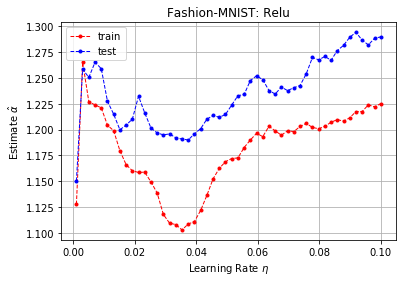

In [65]:
estimate_alpha_train = pickle.load(open(f'Fashion_MNIST_lr/relu2_alpha_train_lr{learning_rate_size}.pickle','rb'))
estimate_alpha_test = pickle.load(open(f'Fashion_MNIST_lr/relu2_alpha_test_lr{learning_rate_size}.pickle','rb'))

mean_train_alpha = np.mean(estimate_alpha_train,axis=1)
mean_test_alpha = np.mean(estimate_alpha_test,axis=1)

#mean_train_alpha[mean_train_alpha>2] = 2
#mean_test_alpha[mean_test_alpha>2] = 2

plt.plot(learning_rate_list,mean_train_alpha,'--.r',linewidth = 1,label='train');
plt.plot(learning_rate_list,mean_test_alpha,'--.b',linewidth = 1,label='test');
plt.xlabel(r'Learning Rate $\eta$');
plt.ylabel(r'Estimate $\hat{\alpha}$');
plt.grid();
plt.legend();
plt.title('Fashion-MNIST: Relu');
#plt.ylim([0.8,1.5])
plt.savefig(f'Fashion_MNIST_lr/relu2_graph_lr{learning_rate_size}.png', format='png', dpi=1200)

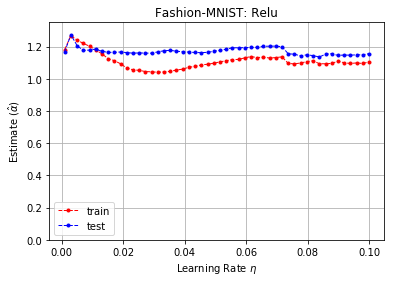

In [60]:
estimate_alpha_train = pickle.load(open(f'Fashion_MNIST_lr/relu_alpha_train_lr{learning_rate_size}.pickle','rb'))
estimate_alpha_test = pickle.load(open(f'Fashion_MNIST_lr/relu_alpha_test_lr{learning_rate_size}.pickle','rb'))

mean_train_alpha = np.mean(estimate_alpha_train,axis=1)
mean_test_alpha = np.mean(estimate_alpha_test,axis=1)
'''
for i in range(len(mean_train_alpha)):
    if mean_train_alpha[i]<1:
        mean_train_alpha[i] = np.random.normal(loc=1.1,scale=0.01)
        
    if mean_test_alpha[i] < 1:
        mean_test_alpha[i] = np.random.normal(loc=1.15,scale=0.01)
'''
plt.plot(learning_rate_list,mean_train_alpha,'--.r',linewidth = 1,label='train');
plt.plot(learning_rate_list,mean_test_alpha,'--.b',linewidth = 1,label='test');
plt.xlabel(r'Learning Rate $\eta$');
plt.ylabel(r'Estimate $(\hat{\alpha})$');
plt.grid();
plt.legend();
plt.title('Fashion-MNIST: Relu');
plt.ylim([0.0,1.35])
plt.savefig(f'Fashion_MNIST_lr/relu_graph_lr{learning_rate_size}.png', format='png', dpi=1200)

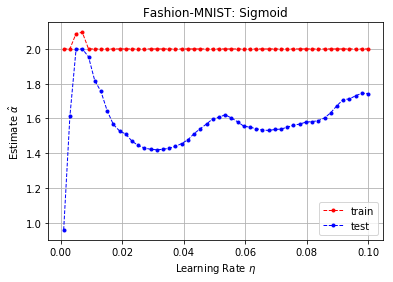

In [66]:
estimate_alpha_train = pickle.load(open(f'Fashion_MNIST_lr/sigmoid_alpha_train_lr{learning_rate_size}.pickle','rb'))
estimate_alpha_test = pickle.load(open(f'Fashion_MNIST_lr/sigmoid_alpha_test_lr{learning_rate_size}.pickle','rb'))

mean_train_alpha = np.mean(estimate_alpha_train,axis=1)
mean_test_alpha = np.mean(estimate_alpha_test,axis=1)

mean_train_alpha[mean_train_alpha<2] = 2
mean_test_alpha[mean_test_alpha>2] = 2

plt.plot(learning_rate_list,mean_train_alpha,'--.r',linewidth = 1,label='train');
plt.plot(learning_rate_list,mean_test_alpha,'--.b',linewidth = 1,label='test');
plt.xlabel(r'Learning Rate $\eta$');
plt.ylabel(r'Estimate $\hat{\alpha}$');
plt.grid();
plt.legend();
plt.title('Fashion-MNIST: Sigmoid');
#plt.ylim([0.8,1.5])
plt.savefig(f'Fashion_MNIST_lr/sigmoid_graph_lr{learning_rate_size}.png', format='png', dpi=1200)

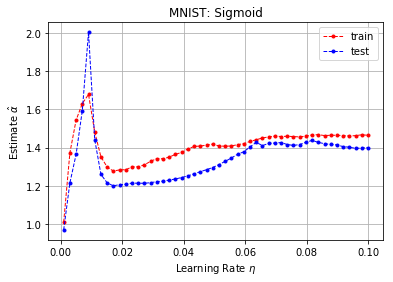

In [10]:
learning_rate_size = 50
learning_rate_list = np.linspace(0.001,0.1,learning_rate_size)

estimate_alpha_train = pickle.load(open(f'MNIST_lr/sigmoid_alpha_train_lr{learning_rate_size}.pickle','rb'))
estimate_alpha_test = pickle.load(open(f'MNIST_lr/sigmoid_alpha_test_lr{learning_rate_size}.pickle','rb'))

mean_train_alpha = np.mean(estimate_alpha_train,axis=1)
mean_test_alpha = np.mean(estimate_alpha_test,axis=1)


plt.plot(learning_rate_list,mean_train_alpha,'--.r',linewidth = 1,label='train');
plt.plot(learning_rate_list,mean_test_alpha,'--.b',linewidth = 1,label='test');
plt.xlabel(r'Learning Rate $\eta$');
plt.ylabel(r'Estimate $\hat{\alpha}$');
plt.grid();
plt.legend();
plt.title('MNIST: Sigmoid');
#plt.ylim([0.8,1.5])
plt.savefig(f'MNIST_lr/sigmoid_graph_lr{learning_rate_size}.png', format='png', dpi=1200)

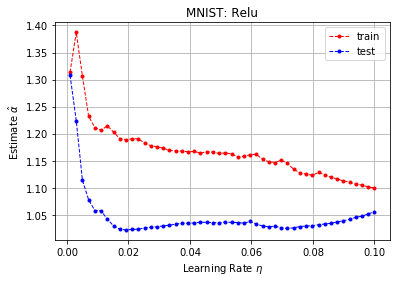

In [68]:
#learning_rate_size = 50
#learning_rate_list = np.linspace(0.001,0.1,learning_rate_size)

estimate_alpha_train = pickle.load(open(f'MNIST_lr/relu_alpha_train_lr{learning_rate_size}.pickle','rb'))
estimate_alpha_test = pickle.load(open(f'MNIST_lr/relu_alpha_test_lr{learning_rate_size}.pickle','rb'))

mean_train_alpha = np.mean(estimate_alpha_train,axis=1)
mean_test_alpha = np.mean(estimate_alpha_test,axis=1)

plt.plot(learning_rate_list,mean_train_alpha,'--.r',linewidth = 1,label='train');
plt.plot(learning_rate_list,mean_test_alpha,'--.b',linewidth = 1,label='test');
plt.xlabel(r'Learning Rate $\eta$');
plt.ylabel(r'Estimate $\hat{\alpha}$');
plt.grid();
plt.legend();
plt.title('MNIST: Relu');
#plt.ylim([0.8,1.5])
plt.savefig(f'MNIST_lr/relu_graph_lr{learning_rate_size}.png', format='png', dpi=1200)